In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate 
import pandas as pd
%matplotlib inline

Set up the paths to the protoDC2v5 data and read the hdf5 file into a pandas dataframe

In [2]:
path = "/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/protoDC2v5"
#path = "/global/u2/s/schmidt9/PZDC2/pz_pdf/notebooks"
infile = "protodc2_v5_ugrizy_witherrs.h5"
#infile = "protodc2_v5_ugrizy_witherrs_training.h5" #this one for just the ~400k training galaxies
fullpath = os.path.join(path,infile)

In [3]:
df = pd.read_hdf(fullpath)

In [4]:
df.head()

,LSST_filters/magnitude:LSST_u:observed:dustAtlas,LSST_filters/magnitude:LSST_g:observed:dustAtlas,LSST_filters/magnitude:LSST_r:observed:dustAtlas,LSST_filters/magnitude:LSST_i:observed:dustAtlas,LSST_filters/magnitude:LSST_z:observed:dustAtlas,LSST_filters/magnitude:LSST_y:observed:dustAtlas,redshift,ra,dec,galaxyID,...,scaterr_g,scatmag_r,scaterr_r,scatmag_i,scaterr_i,scatmag_z,scaterr_z,scatmag_y,scaterr_y,training_flag
0,21.234911,20.090427,19.677958,19.508871,19.484373,19.435213,0.024627,-0.213268,-1.780913,0,...,0.005042,19.682526,0.005018,19.511381,0.005024,19.489855,0.005056,19.441219,0.005206,False
1,21.839048,20.748993,20.418985,20.241453,20.190296,20.152172,0.024598,-1.293915,-2.062044,1,...,0.005106,20.422693,0.005048,20.244062,0.005066,20.176054,0.005158,20.159077,0.005648,False
2,21.023718,20.142702,19.991816,19.915903,19.910103,19.878025,0.024227,0.681523,-1.484340,2,...,0.005046,20.002113,0.005027,19.907297,0.005041,19.912237,0.005105,19.876188,0.005412,False
3,17.604139,16.012825,15.264262,14.847938,14.583278,14.419316,0.024483,-0.304187,-0.923260,3,...,0.005001,15.266548,0.005000,14.850696,0.005000,14.585126,0.005000,14.416851,0.005001,False
4,19.315104,18.073452,17.455185,17.079489,16.859879,16.746384,0.024451,-0.261973,-0.874825,4,...,0.005004,17.459517,0.005001,17.078701,0.005002,16.857254,0.005002,16.738359,0.005006,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18286706 entries, 0 to 18286705
Data columns (total 23 columns):
LSST_filters/magnitude:LSST_u:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_g:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_r:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_i:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_z:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_y:observed:dustAtlas    float32
redshift                                            float64
ra                                                  float32
dec                                                 float32
galaxyID                                            int64
scatmag_u                                           float32
scaterr_u                                           float32
scatmag_g                                           float32
scaterr_g                                           float32
scatmag_r                                      

Plot a histogram of the apparent magnitude number counts.  We want to select a flat/Uniform set of galaxies in terms of apparent i-band magnitude.  The total number of galaxies that we want in the training sample is defined as N_tot.  We will also define the number of bins and the range over which we want to calculate the histogram

In [6]:
N_tot = 105000
N_bins = 20
i_min = 18.
i_max = 25.

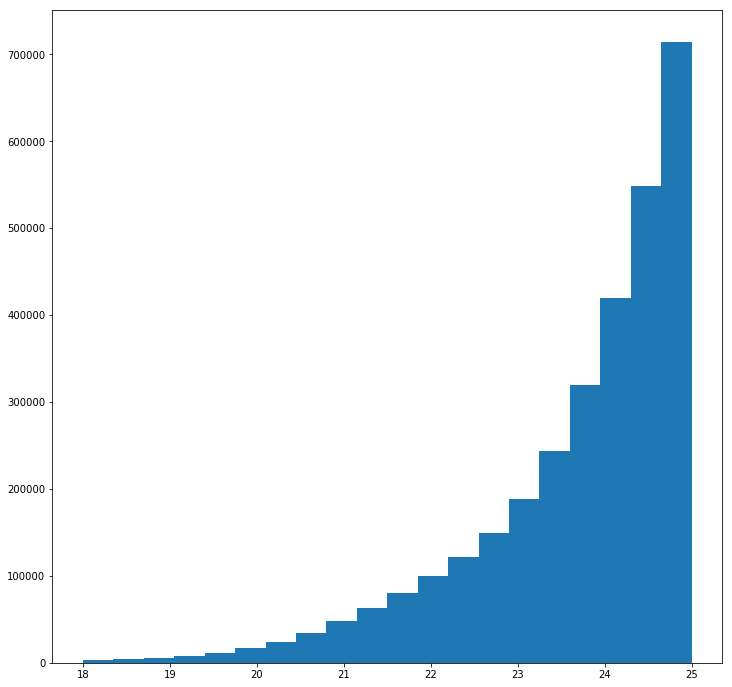

In [7]:
fig = plt.figure(figsize=(12,12))
hist_n, binedges, hist_patches = plt.hist(df['scatmag_i'],bins=N_bins,range=(i_min,i_max))

In [8]:
print (hist_n,binedges)

[   2893.    4076.    5844.    8241.   11637.   16955.   24502.   34385.
   48011.   63370.   80726.  100368.  121577.  149520.  188045.  243211.
  319277.  419505.  548529.  714757.] [ 18.    18.35  18.7   19.05  19.4   19.75  20.1   20.45  20.8   21.15
  21.5   21.85  22.2   22.55  22.9   23.25  23.6   23.95  24.3   24.65  25.  ]


In order to get a uniform number per magnitude slice we can just make a random number between 0 and 1 for each galaxy and weight by the inverse of the number counts histogram.  If we then use this weight as a threshold, we will select the same number of galaxies per magnitude bin.  num_per_bin will be the number selected per bin, the total desired divided by the number of bins..

In [9]:
inv_n = 1./hist_n
num_per_bin = N_tot/N_bins
print (num_per_bin)

5250.0


In [10]:
weight = num_per_bin/hist_n
print (weight)

[ 1.8147252   1.28802748  0.89835729  0.63705861  0.4511472   0.30964317
  0.21426822  0.15268286  0.10934994  0.08284677  0.06503481  0.05230751
  0.04318251  0.03511236  0.02791885  0.02158619  0.0164434   0.01251475
  0.00957105  0.00734515]


Note that the weight is >1 for the first two bins, and thus *all* galaxies in those bins will be selected, while in the final bin between 24.64 and 25. the weight is only 0.00734, so less than 1percent of those galaxies will be selected for the training set

In [11]:
bincents = 0.5*(binedges[1:]+binedges[:-1])
print(binedges)
print(bincents)

[ 18.    18.35  18.7   19.05  19.4   19.75  20.1   20.45  20.8   21.15
  21.5   21.85  22.2   22.55  22.9   23.25  23.6   23.95  24.3   24.65  25.  ]
[ 18.175  18.525  18.875  19.225  19.575  19.925  20.275  20.625  20.975
  21.325  21.675  22.025  22.375  22.725  23.075  23.425  23.775  24.125
  24.475  24.825]


Create a 1d interpolation function with linear interpolation to define the weight threshold continuously as a function of i-band magnitude.  Set the weigt to just return the boundary values below and above the defined bin boundaries

In [12]:
weightFunc = scipy.interpolate.interp1d(bincents,weight,kind='linear',bounds_error=False,fill_value=(weight[0],weight[-1]))

In [13]:
randoms = np.random.rand(len(df['scatmag_i']))
allweights = weightFunc(df['scatmag_i'])

In [14]:
flat_train_mask = np.logical_and(randoms<allweights,df['scatmag_i']<25.)

In [15]:
print (np.sum(flat_train_mask))

107327


In [16]:
train_col_name = 'flat_training_flag'
df[train_col_name]=flat_train_mask

In [17]:
flat_train_i = df['scatmag_i'][flat_train_mask]

Make a plot of the number counts for the full sample and those selected in the training set

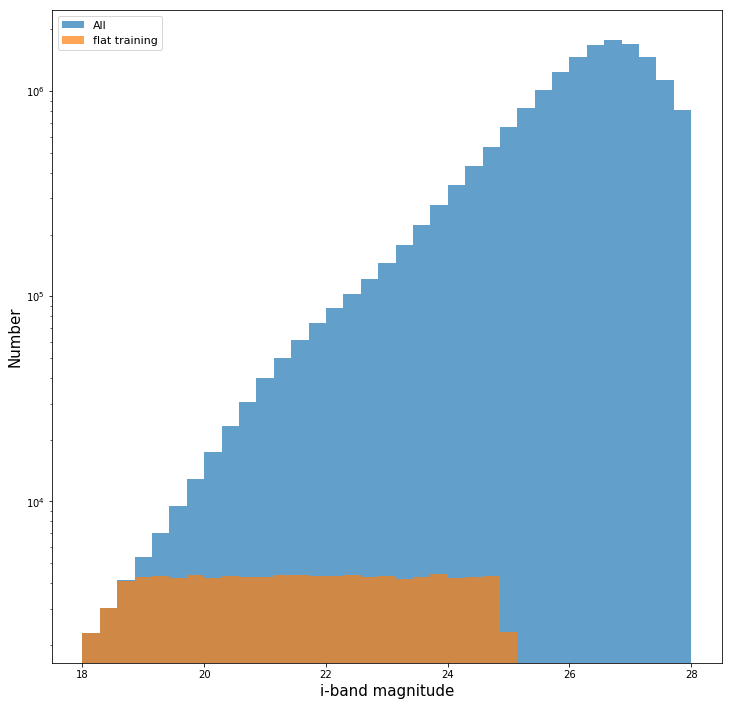

In [18]:
fig = plt.figure(figsize=(12,12))
nall,binedgeall,pathesall = plt.hist(df['scatmag_i'],bins=35,range=(18.,28.),alpha=0.7,label='All')
ntrain, binedgestrain, patchestrain = plt.hist(flat_train_i,bins=35,range=(18.,28.),alpha=0.7,label='flat training')
plt.yscale('log')
plt.xlabel('i-band magnitude',fontsize=15)
plt.ylabel('Number',fontsize=15)
plt.legend(loc='upper left',fontsize=11)

Now, make a plot of the redshift distribution of the full sample as well as the flat training sample

In [19]:
flat_train_sz = df['redshift'][flat_train_mask]

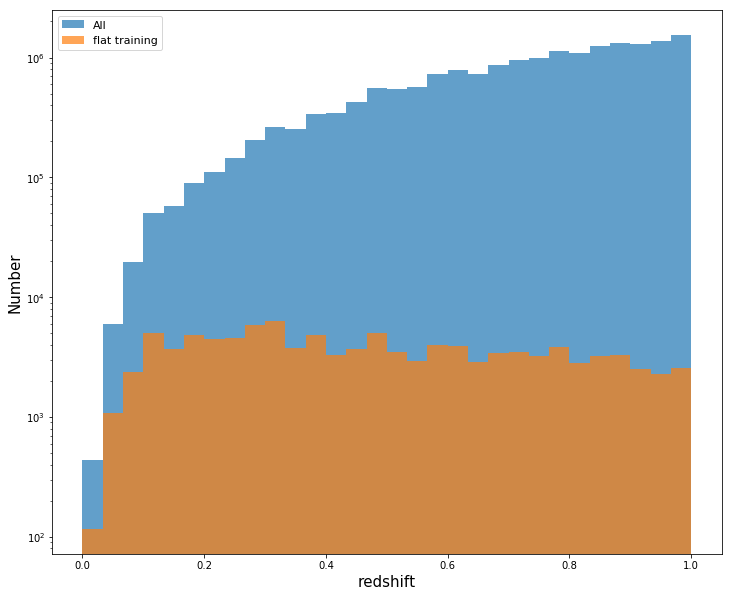

In [20]:
fig = plt.figure(figsize=(12,10))
zall,zbinedges,zbinpatches = plt.hist(df['redshift'],bins=30,range=(0.,1.),alpha=0.7,label='All')
sztrain, szbinedgestrain, szpatchestrain = plt.hist(flat_train_sz,bins=30,range=(0.,1.),alpha=0.7,label='flat training')
plt.yscale('log')
plt.xlabel('redshift',fontsize=15)
plt.ylabel('Number',fontsize=15)
plt.legend(loc='upper left',fontsize=11)

Looks as expected, so let's write out the subset that have flat_training_flag set to True to their own HDF5 file

In [23]:
df_flat_train = df[df['flat_training_flag']==True]
outfile_protodc2_flat_training = "protodc2_v5_ugrizy_witherrs_flat_training.h5"
#comment out for now so I don't accidentally overwrite
#df_flat_train.to_hdf(outfile_protodc2_flat_training, 'df_flat_train')